## Fast Fourier Transform

- Libraries

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft, fftfreq
plt.style.use('classic')

- Get Data

In [3]:
'''
The acelerations are in m/s and the gyros in rad/s
'''
data = pd.read_csv('aceleraciones.csv', sep=';') 
data.head(3)

,Aceleracion_X0,Aceleracion_Y0,Aceleracion_Z0,Gyro_X0,Gyro_Y0,Gyro_Z0,Temperatura1,Aceleracion_X1,Aceleracion_Y1,Aceleracion_Z1,Gyro_X1,Gyro_Y1,Gyro_Z1,Temperatura1.1
0,"-8,77","-1,34","-2,92","0,09","0,09","-0,06","23,16","-9,37","0,14","-3,33","0,13","-0,01","0,05","24,13"
1,"-8,69","-1,17","-3,44","-0,06","-0,15","0,04","23,18","-9,43","-0,18","-3,58","-0,11","-0,03","-0,11","24,13"
2,"-7,52","-3,99","-2,34","0,24","0,26","-0,83","23,19","-7,96","0,14","-1,53","0,72","0,69","-1,58","24,13"


- Graphics

In [22]:
for name in data.columns:
    data[name] = data[name].str.replace(',','.').astype(float)

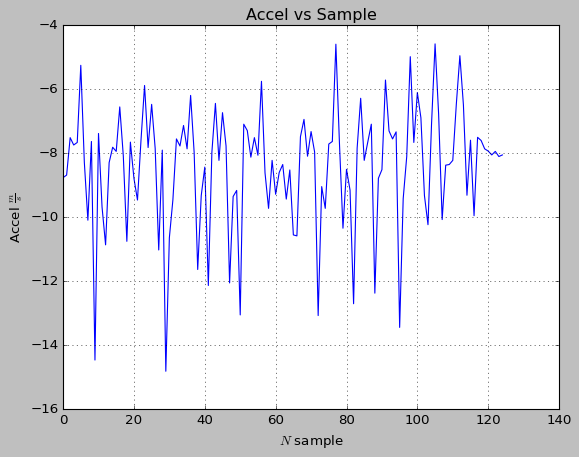

In [55]:
samples = len(data['Aceleracion_X0'])
total_time = 0.5*samples
v_sam = np.linspace(0,samples-1,125)
data['Aceleracion_X0'].plot()
accx = data['Aceleracion_X0'].to_numpy()
plt.xlabel('$N$ sample')
plt.ylabel(r'Accel $\frac{m}{s}$')
plt.title('Accel vs Sample')
plt.grid()
plt.show()

- Frecuency Domain

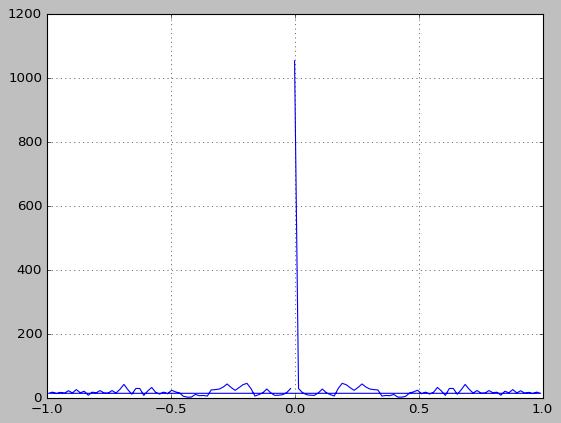

In [47]:
sample_rate = 1/0.5 # Hz 1/0.5s
yf = fft(accx)
n = np.arange(samples)
T = samples/samples

xf = fftfreq(samples, 1/sample_rate )
plt.plot(xf, np.abs(yf))
plt.grid()
plt.show()

In [54]:
def RMS(vector):    
    x_rms = 0
    sum_accx = 0
    for i in vector:
        sum_accx += i**2 
    x_rms = (sum_accx/len(vector))**(1/2)
    return x_rms

In [51]:
cero_freq = np.where(xf == 0)[0][0]
print(accx.mean())
medium_value = ifft(yf)[cero_freq]
print(medium_value)

-8.418159999999999
(-8.769999999999998+2.2737367544323206e-16j)


- BandWight of filter

c:\Users\danie\AppData\Local\Programs\Python\Python38\lib\site-packages\matplotlib\cbook\__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


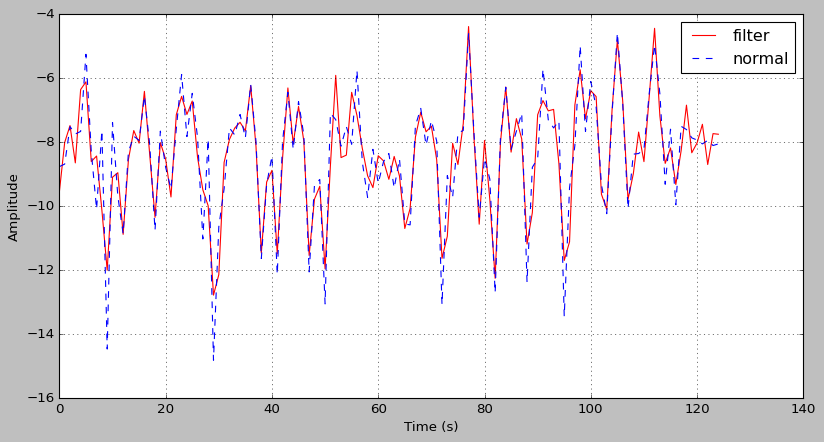

In [63]:
sig_fft_accx = yf.copy()
cut_off = 0.7
sig_fft_accx[np.abs(xf) > cut_off] = 0
filtered = ifft(sig_fft_accx)
# plot the filtered signal
plt.figure(figsize = (12, 6))
plt.plot(v_sam, filtered, c='red')
plt.plot(v_sam, accx, linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend(["filter", "normal"])
plt.grid()
plt.show()